### Import Libraries

In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier

from sklearn.base import clone

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA, FastICA
from sklearn.pipeline import Pipeline
from sklearn.metrics import (auc, roc_curve)


### Data Loading and Initial Exploration

In this step, we load the SECOM dataset from Google Drive into a pandas DataFrame. The target labels in the `Pass/Fail` column are converted for consistency, where `1` indicates a **pass** and `0` indicates a **fail**. We then display the dataset's shape, a summary of the class distribution, the first few rows, and key statistics such as column-wise descriptions and data types to understand the structure and quality of the data.


In [ ]:
file_path = "../data/uci-secom.csv"
df = pd.read_csv(file_path)

df['Pass/Fail'] = df['Pass/Fail'].replace({1: 0, -1: 1}) # Pass = 1 , Fail = 0

print("Data shape:", df.shape)
print(df['Pass/Fail'].value_counts())
df.head()

Data shape: (1567, 592)
Pass/Fail
1    1463
0     104
Name: count, dtype: int64


,Time,0,1,2,3,4,5,6,7,8,...,581,582,583,584,585,586,587,588,589,Pass/Fail
0,2008-07-19 11:55:00,3030.93,2564.00,2187.7333,1411.1265,1.3602,100.0,97.6133,0.1242,1.5005,...,NaN,0.5005,0.0118,0.0035,2.3630,NaN,NaN,NaN,NaN,1
1,2008-07-19 12:32:00,3095.78,2465.14,2230.4222,1463.6606,0.8294,100.0,102.3433,0.1247,1.4966,...,208.2045,0.5019,0.0223,0.0055,4.4447,0.0096,0.0201,0.0060,208.2045,1
2,2008-07-19 13:17:00,2932.61,2559.94,2186.4111,1698.0172,1.5102,100.0,95.4878,0.1241,1.4436,...,82.8602,0.4958,0.0157,0.0039,3.1745,0.0584,0.0484,0.0148,82.8602,0
3,2008-07-19 14:43:00,2988.72,2479.90,2199.0333,909.7926,1.3204,100.0,104.2367,0.1217,1.4882,...,73.8432,0.4990,0.0103,0.0025,2.0544,0.0202,0.0149,0.0044,73.8432,1
4,2008-07-19 15:22:00,3032.24,2502.87,2233.3667,1326.5200,1.5334,100.0,100.3967,0.1235,1.5031,...,NaN,0.4800,0.4766,0.1045,99.3032,0.0202,0.0149,0.0044,73.8432,1


In [3]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
0,1561.0,3014.452896,73.621787,2743.2400,2966.260000,3011.4900,3056.6500,3356.3500
1,1560.0,2495.850231,80.407705,2158.7500,2452.247500,2499.4050,2538.8225,2846.4400
2,1553.0,2200.547318,29.513152,2060.6600,2181.044400,2201.0667,2218.0555,2315.2667
3,1553.0,1396.376627,441.691640,0.0000,1081.875800,1285.2144,1591.2235,3715.0417
4,1553.0,4.197013,56.355540,0.6815,1.017700,1.3168,1.5257,1114.5366
...,...,...,...,...,...,...,...,...
586,1566.0,0.021458,0.012358,-0.0169,0.013425,0.0205,0.0276,0.1028
587,1566.0,0.016475,0.008808,0.0032,0.010600,0.0148,0.0203,0.0799
588,1566.0,0.005283,0.002867,0.0010,0.003300,0.0046,0.0064,0.0286
589,1566.0,99.670066,93.891919,0.0000,44.368600,71.9005,114.7497,737.3048


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1567 entries, 0 to 1566
Columns: 592 entries, Time to Pass/Fail
dtypes: float64(590), int64(1), object(1)
memory usage: 7.1+ MB


### Missing Data Analysis

This section analyzes missing values in the dataset. First, it calculates the percentage of missing values for each column and categorizes them into bins (e.g., 0–10%, 10–20%, etc.) to understand the overall distribution of missing data. A bar plot is then generated to visualize the top 50 features with the highest percentage of missing values. Finally, the number of features with more than 50% missing data is reported, which is important for deciding how to handle or remove unreliable features.


In [5]:
nan_percentage = df.isna().mean() * 100

bins = list(range(0, 110, 10))
labels = [f"{i}-{i+10}%" for i in bins[:-1]]
binned = pd.cut(nan_percentage, bins=bins, labels=labels, right=False)

nan_distribution = binned.value_counts().sort_index()

print(nan_distribution)

0-10%      540
10-20%      20
20-30%       0
30-40%       0
40-50%       4
50-60%       4
60-70%      16
70-80%       0
80-90%       4
90-100%      4
Name: count, dtype: int64


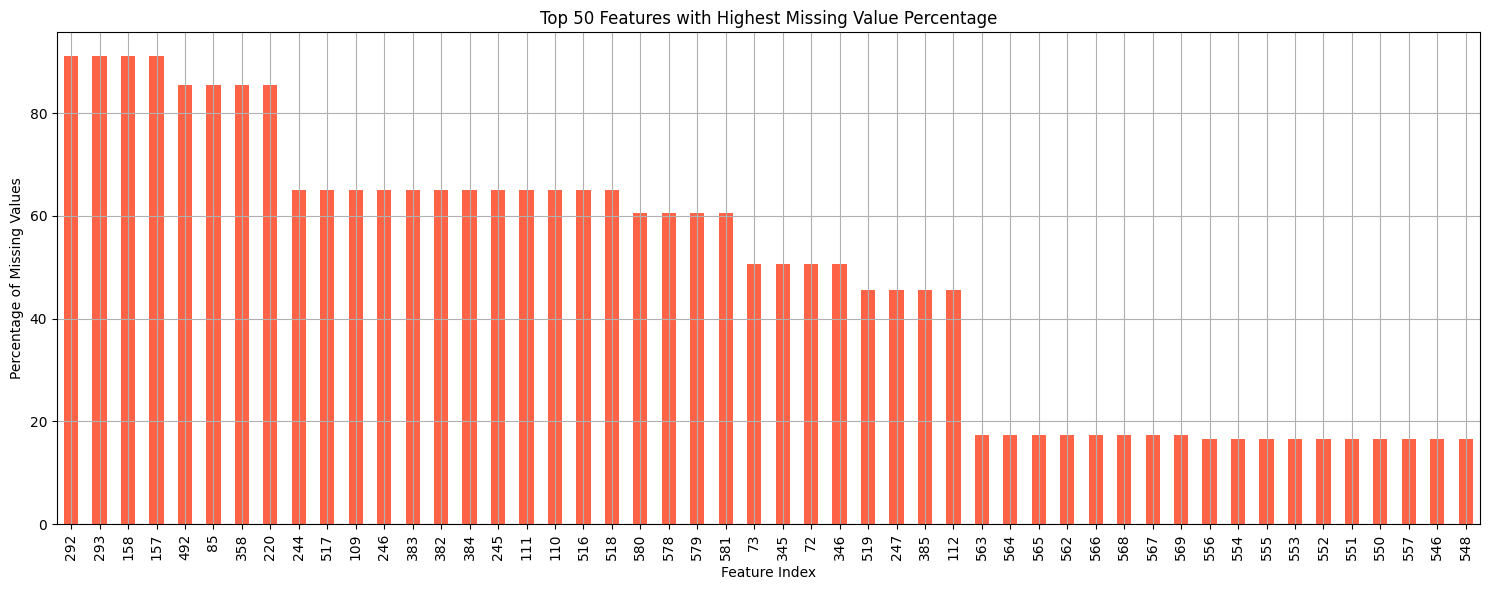


Number of columns with > 50% NaNs: 28


In [6]:
features_only = df.drop(columns=['Pass/Fail', 'Time'])
missing_percent = features_only.isnull().mean() * 100
missing_percent = missing_percent.sort_values(ascending=False)

plt.figure(figsize=(15, 6))
missing_percent[:50].plot(kind='bar', color='tomato')
plt.title("Top 50 Features with Highest Missing Value Percentage")
plt.ylabel("Percentage of Missing Values")
plt.xlabel("Feature Index")
plt.grid(True)
plt.tight_layout()
plt.show()

high_nan_columns = missing_percent[missing_percent > 50]
print(f"\nNumber of columns with > 50% NaNs: {len(high_nan_columns)}")


### Data Preprocessing: Handling Missing Values and Scaling

In this step, we prepare the dataset for modeling by separating features (`X`) from the target (`y`) and handling missing values. Missing data in each feature column is filled using a **rolling median** with a window size of 11 (centered), which helps preserve local trends while smoothing noise. For any remaining missing values (typically at the edges), we apply a fallback by filling them with the column median. Finally, the features are standardized using `StandardScaler` to ensure all variables contribute equally to the model, improving training performance and convergence.


In [7]:
X = df.drop(columns=['Pass/Fail', 'Time'], errors='ignore')
y = df['Pass/Fail'].values

# Apply rolling median per column to fill missing values
# Window size: 11 (5 before + 5 after + current)
window_size = 11
X_rolled = X.copy()

for col in X_rolled.columns:
    if X_rolled[col].isna().any():
        X_rolled[col] = X_rolled[col].fillna(
            X_rolled[col].rolling(window=window_size, center=True, min_periods=1).median()
        )

# Fill any remaining NaNs (e.g. at edges) using column median as fallback
X_rolled = X_rolled.fillna(X_rolled.median())

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_rolled)


### Feature Importance and Selection using Tree-Based Models

In this section, we evaluate feature importance using two ensemble methods: **ExtraTreesClassifier** and **RandomForestClassifier**. Both models are trained on the scaled feature set, and feature importances are extracted to identify the most relevant predictors of product quality (`Pass/Fail`).

- **ExtraTreesClassifier**: A highly randomized tree ensemble that often yields robust importance estimates.
- **RandomForestClassifier**: A widely used ensemble model; here, it's configured with `class_weight='balanced'` to account for any class imbalance.

#### Key Steps:
1. **Feature Importance Calculation**: Importance scores from both models are saved and compared side by side for the top 20 features using a horizontal bar plot.
2. **Feature Selection**: To reduce dimensionality while preserving predictive power, we select features that collectively account for **90% of the total importance** in each model.
3. **Reduced Feature Sets**: Two separate reduced datasets are created (one for ExtraTrees and one for RandomForest) using only the selected features.

This process helps identify the most influential features and enables the construction of simpler, faster, and potentially more interpretable models downstream.


In [8]:
# Train ExtraTreesClassifier
et_model = ExtraTreesClassifier(n_estimators=300, random_state=42)
et_model.fit(X_scaled, y)

et_importances = et_model.feature_importances_

# Save to DataFrame
importances_df = pd.DataFrame({
    'feature': X.columns,
    'importance': et_importances
}).sort_values(by='importance', ascending=False)


In [9]:
# Train Random Forest
rf_model = RandomForestClassifier(n_estimators=300, random_state=42, class_weight='balanced')
rf_model.fit(X_scaled, y)

rf_importances = rf_model.feature_importances_

# Create DataFrame
rf_importances_df = pd.DataFrame({
    'feature': X.columns,
    'rf_importance': rf_importances
}).sort_values(by='rf_importance', ascending=False)


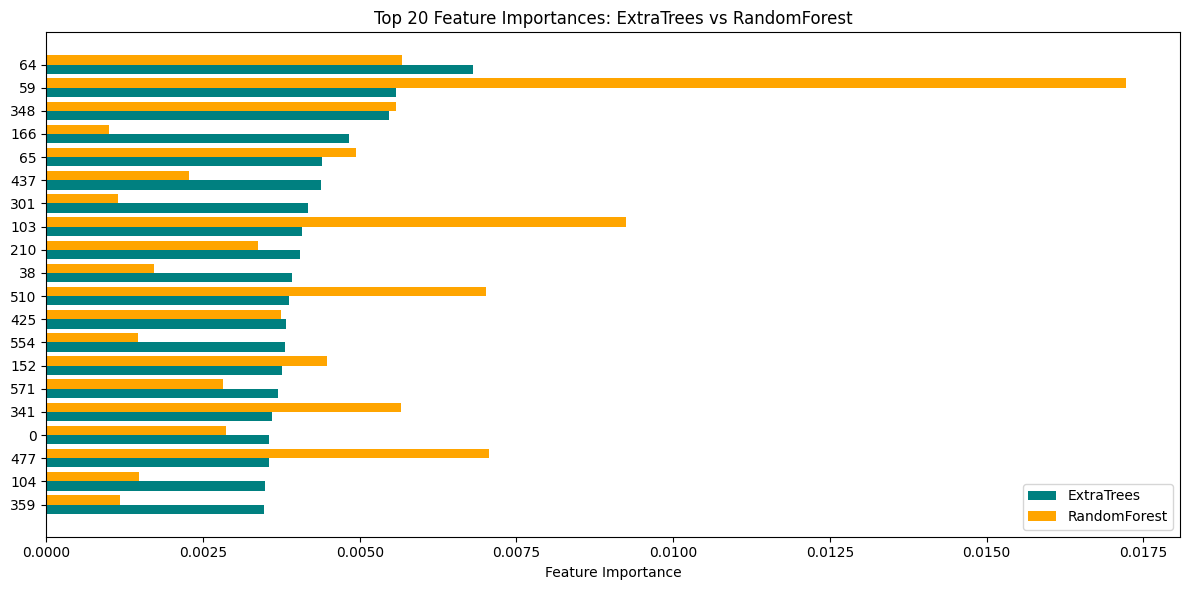

In [10]:
# Merge with ExtraTrees importances
merged_importances = importances_df.merge(rf_importances_df, on='feature')

# Plot both side by side
top_n = 20
top_features = merged_importances.head(top_n)

plt.figure(figsize=(12, 6))
bar_width = 0.4
indices = range(top_n)

plt.barh([i + bar_width for i in indices], top_features['importance'], height=bar_width, label='ExtraTrees', color='teal')
plt.barh(indices, top_features['rf_importance'], height=bar_width, label='RandomForest', color='orange')
plt.yticks([i + bar_width/2 for i in indices], top_features['feature'])
plt.xlabel('Feature Importance')
plt.title('Top 20 Feature Importances: ExtraTrees vs RandomForest')
plt.legend()
plt.tight_layout()
plt.gca().invert_yaxis()
plt.show()


In [11]:
# === From ExtraTrees ===
threshold_et = 0.90  # Keep features that explain 90% of total importance
et_cum_importance = importances_df['importance'].cumsum()
et_selected_features = importances_df[et_cum_importance <= threshold_et]['feature'].tolist()

# Create reduced feature DataFrame for ExtraTrees
X_et = X_scaled[:, [X.columns.get_loc(feat) for feat in et_selected_features]]
et_df = pd.DataFrame(X_et, columns=et_selected_features)
et_df['Pass/Fail'] = y

print(f"ExtraTrees selected {len(et_selected_features)} features.")

# === From RandomForest ===
threshold_rf = 0.90
rf_cum_importance = rf_importances_df['rf_importance'].cumsum()
rf_selected_features = rf_importances_df[rf_cum_importance <= threshold_rf]['feature'].tolist()

# Create reduced feature DataFrame for RandomForest
X_rf = X_scaled[:, [X.columns.get_loc(feat) for feat in rf_selected_features]]
rf_df = pd.DataFrame(X_rf, columns=rf_selected_features)
rf_df['Pass/Fail'] = y

print(f"RandomForest selected {len(rf_selected_features)} features.")

ExtraTrees selected 391 features.
RandomForest selected 367 features.


### Correlation Analysis, Feature Reduction, and PCA on Selected Features

After selecting important features from the ExtraTrees and RandomForest models, we further analyze their relationships and reduce redundancy:

1. **Correlation Heatmaps**  
   We compute and visualize correlation matrices for both sets of selected features to identify highly correlated variables. Strong correlations may indicate redundant information that can negatively impact model performance or interpretability.

2. **Removing Highly Correlated Features**  
   Using a threshold (default 0.9), we automatically drop features that are highly correlated with others in the dataset. This step reduces multicollinearity and simplifies the feature space.

3. **Applying PCA for Dimensionality Reduction**  
   Principal Component Analysis (PCA) is applied twice:  
   - On the original selected feature sets.  
   - On the de-correlated (cleaned) feature sets.  
   
   PCA transforms the features into a smaller set of orthogonal components that preserve 95% of the variance, further simplifying the data while retaining most of its information.

This multi-step process ensures that the final features used for modeling are both important and minimally redundant, leading to more efficient and robust models.


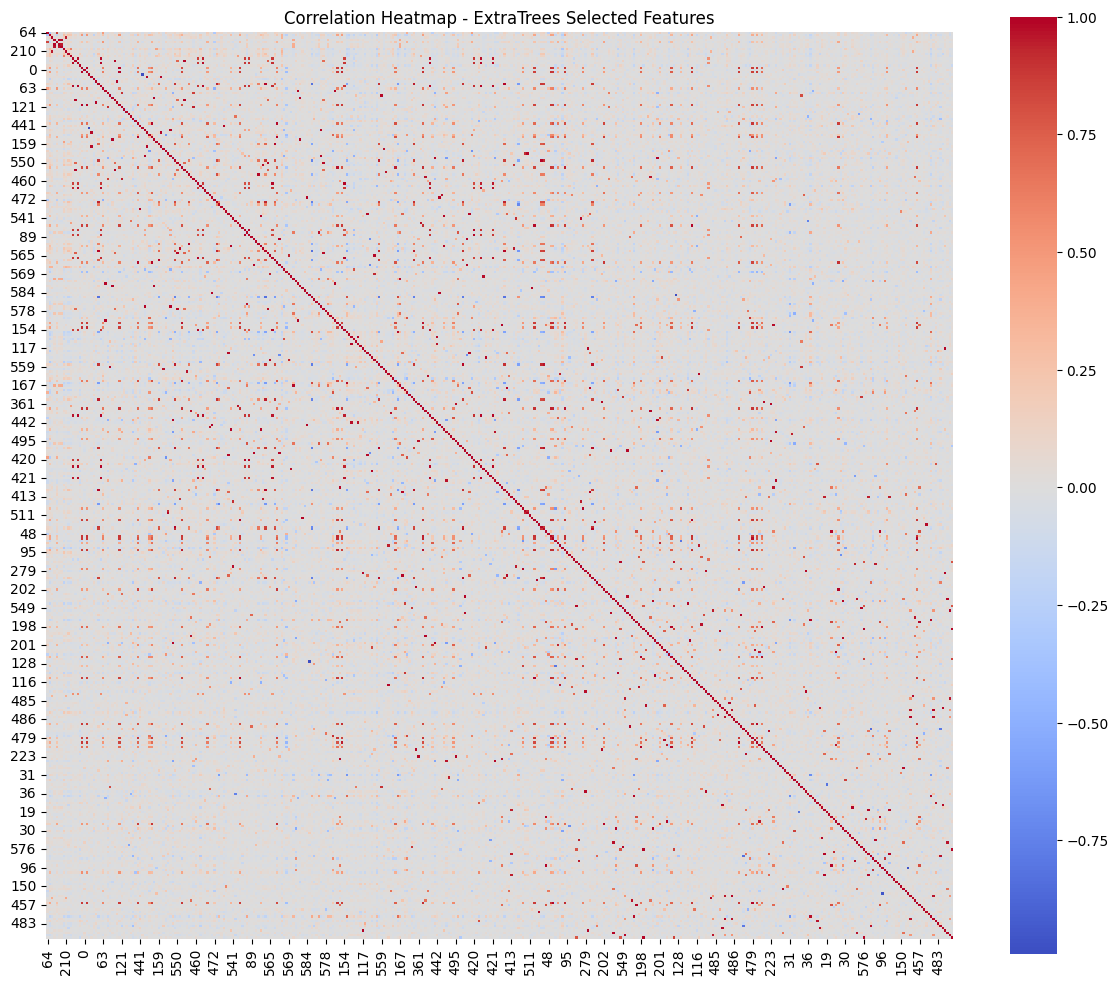

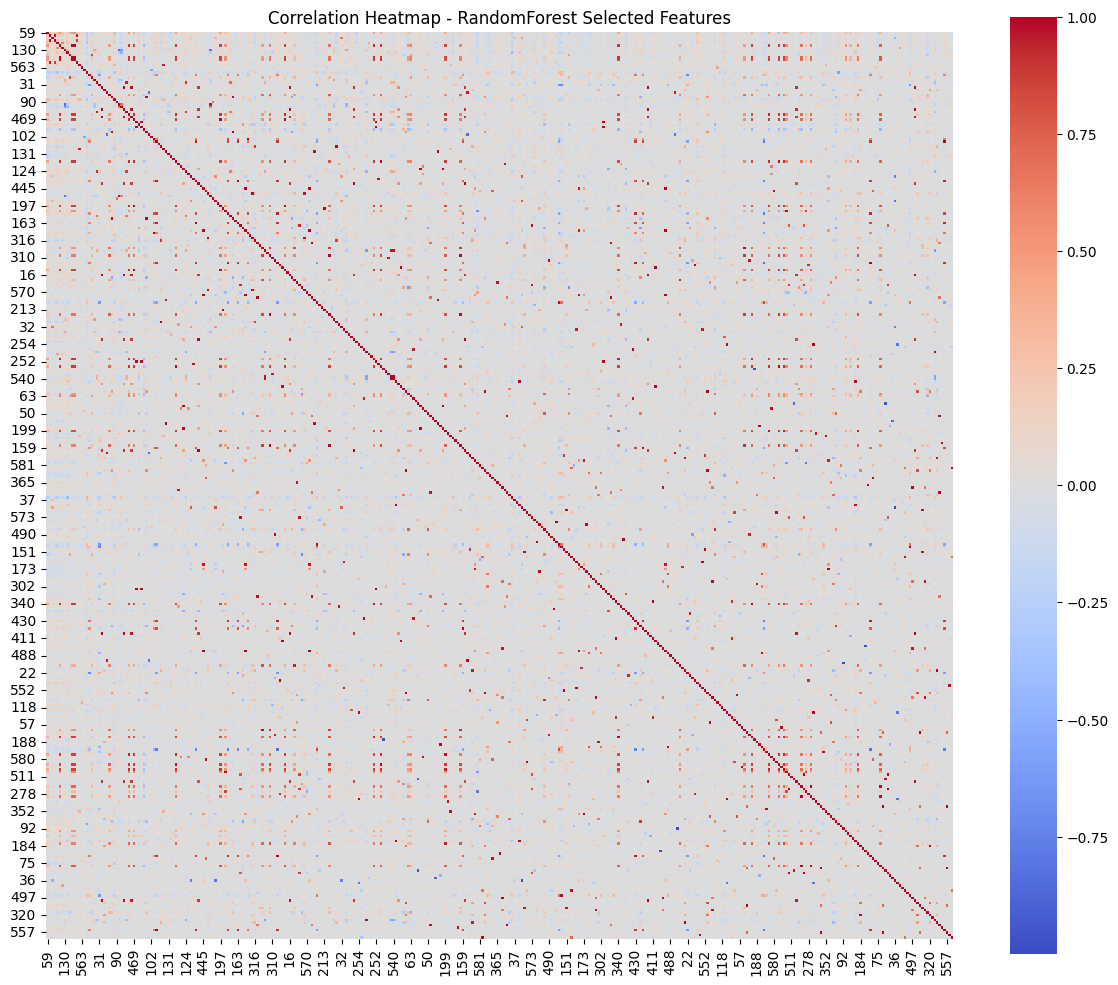

In [12]:
# Remove target column before correlation
et_corr = et_df.drop(columns='Pass/Fail').corr()
rf_corr = rf_df.drop(columns='Pass/Fail').corr()

# === ExtraTrees correlation heatmap ===
plt.figure(figsize=(12, 10))
sns.heatmap(et_corr, cmap='coolwarm', center=0, square=True)
plt.title("Correlation Heatmap - ExtraTrees Selected Features")
plt.tight_layout()
plt.show()

# === RandomForest correlation heatmap ===
plt.figure(figsize=(12, 10))
sns.heatmap(rf_corr, cmap='coolwarm', center=0, square=True)
plt.title("Correlation Heatmap - RandomForest Selected Features")
plt.tight_layout()
plt.show()

#### Correlation Heatmaps – ExtraTrees vs. RandomForest Selected Features

These heatmaps visualize the **pairwise Pearson correlations** between features selected by ExtraTrees and RandomForest.

- **Up (ExtraTrees)**: Many features show moderate to high correlation, indicating potential redundancy.
- **Down (RandomForest)**: Fewer highly correlated pairs, suggesting more diverse feature selection.

#### Why This Matters:
Highly correlated features can introduce **multicollinearity**, potentially harming model interpretability and increasing the risk of overfitting. These plots help identify and address such redundancy by guiding feature pruning.


In [13]:
# Function to drop highly correlated features
def drop_highly_correlated(df, threshold=0.95):
    X = df.drop(columns='Pass/Fail')
    y = df['Pass/Fail']
    corr_matrix = X.corr().abs()
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    to_drop = [column for column in upper.columns if any(upper[column] > threshold)]
    print(f"Dropping {len(to_drop)} highly correlated features (correlation > {threshold})")
    reduced_df = X.drop(columns=to_drop)
    reduced_df['Pass/Fail'] = y
    return reduced_df

# Clean versions of your selected feature sets
et_df_uncorr = drop_highly_correlated(et_df, threshold=0.9)
rf_df_uncorr = drop_highly_correlated(rf_df, threshold=0.9)

Dropping 163 highly correlated features (correlation > 0.9)
Dropping 140 highly correlated features (correlation > 0.9)


In [14]:
# Function to apply PCA to any feature set (excluding target)
def apply_pca(df, variance_threshold=0.90):
    X_sel = df.drop(columns='Pass/Fail').values
    y_sel = df['Pass/Fail'].values
    pca = PCA(n_components=variance_threshold, random_state=42)
    X_pca = pca.fit_transform(X_sel)
    print(f"PCA reduced from {X_sel.shape[1]} to {X_pca.shape[1]} components to preserve {variance_threshold*100:.0f}% variance.")
    pca_df = pd.DataFrame(X_pca, columns=[f'PC{i+1}' for i in range(X_pca.shape[1])])
    pca_df['Pass/Fail'] = y_sel
    return pca_df

In [15]:
# PCA on correlated feature sets
et_pca_df = apply_pca(et_df)
rf_pca_df = apply_pca(rf_df)

# PCA on de-correlated feature sets
et_pca_uncorr_df = apply_pca(et_df_uncorr)
rf_pca_uncorr_df = apply_pca(rf_df_uncorr)


PCA reduced from 391 to 121 components to preserve 90% variance.
PCA reduced from 367 to 122 components to preserve 90% variance.
PCA reduced from 228 to 128 components to preserve 90% variance.
PCA reduced from 227 to 128 components to preserve 90% variance.


### Data Splitting: Stratified Train-Test Split

To evaluate model performance reliably, the dataset is split into training and testing sets using a **stratified sampling strategy** based on the target variable (`Pass/Fail`). This ensures that both sets maintain the same class distribution, which is crucial for classification tasks involving imbalanced data.

A custom utility function, `split_data`, performs this operation by:

- Dropping the target column from the features.
- Applying `train_test_split` with stratification.
- Storing the resulting splits (`X_train`, `X_test`, `y_train`, `y_test`) in a shared `splits` dictionary under a user-defined name.


In [16]:
splits = {}

def split_data(df, name, test_size=0.2, random_state=42):
    X = df.drop(columns='Pass/Fail').values
    y = df['Pass/Fail'].values

    X_train, X_test, y_train, y_test = train_test_split(
        X, y,
        test_size=test_size,
        random_state=random_state,
        stratify=y
    )

    splits[name] = {
        'X_train': X_train,
        'X_test': X_test,
        'y_train': y_train,
        'y_test': y_test
    }

    print(f"[{name}]: Train: {X_train.shape}, Test: {X_test.shape}, Class balance (train): {np.bincount(y_train)}, (test): {np.bincount(y_test)}")


In [ ]:
split_data(et_df, "ET_raw")
split_data(rf_df, "RF_raw")
split_data(et_df_uncorr, "ET_uncorr")
split_data(rf_df_uncorr, "RF_uncorr")
split_data(et_pca_df, "ET_PCA")
split_data(rf_pca_df, "RF_PCA")
split_data(et_pca_uncorr_df, "ET_PCA_uncorr")
split_data(rf_pca_uncorr_df, "RF_PCA_uncorr")

[ET_raw]: Train: (1253, 391), Test: (314, 391), Class balance (train): [  83 1170], (test): [ 21 293]
[RF_raw]: Train: (1253, 367), Test: (314, 367), Class balance (train): [  83 1170], (test): [ 21 293]
[ET_uncorr]: Train: (1253, 228), Test: (314, 228), Class balance (train): [  83 1170], (test): [ 21 293]
[RF_uncorr]: Train: (1253, 227), Test: (314, 227), Class balance (train): [  83 1170], (test): [ 21 293]
[ET_PCA]: Train: (1253, 121), Test: (314, 121), Class balance (train): [  83 1170], (test): [ 21 293]
[RF_PCA]: Train: (1253, 122), Test: (314, 122), Class balance (train): [  83 1170], (test): [ 21 293]
[ET_PCA_uncorr]: Train: (1253, 128), Test: (314, 128), Class balance (train): [  83 1170], (test): [ 21 293]
[RF_PCA_uncorr]: Train: (1253, 128), Test: (314, 128), Class balance (train): [  83 1170], (test): [ 21 293]


### Model Training: Stratified Cross-Validation

To evaluate the performance of various classification algorithms, a set of models is trained and validated using **stratified k-fold cross-validation**. This approach ensures that each fold preserves the class distribution of the target variable (`Pass/Fail`), which is essential for imbalanced datasets.

A collection of models is predefined, including both linear and non-linear classifiers:

- `LogisticRegression`
- `RandomForestClassifier`
- `DecisionTreeClassifier`
- `GaussianNB`
- `KNeighborsClassifier`
- `SVC` (Support Vector Classifier)
- `XGBoostClassifier`

Each model is configured with appropriate parameters, such as `class_weight='balanced'` to address class imbalance.

The `run_cross_validation` function performs the following for each dataset:

- Retrieves training data from the `splits` dictionary.
- Applies **7-fold stratified cross-validation** (`StratifiedKFold`).
- Evaluates each model using five metrics:
  - Accuracy
  - Precision
  - Recall
  - F1 Score
  - ROC AUC
- Aggregates the average scores across folds.
- Stores the results in a centralized `cv_results` dictionary for later analysis.



In [18]:
models = {
    'LogisticRegression': LogisticRegression(max_iter=1000, class_weight='balanced'),
    'RandomForest': RandomForestClassifier(n_estimators=300, class_weight='balanced', random_state=42),
    'DecisionTree': DecisionTreeClassifier(class_weight='balanced', random_state=42),
    'GaussianNB': GaussianNB(),
    'KNN': KNeighborsClassifier(),
    'SVC': SVC(probability=True, class_weight='balanced', random_state=42),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss', scale_pos_weight=12, random_state=42)
}

# Dictionary to store CV results
cv_results = {}

def run_cross_validation(dataset_name, cv_folds=7):
    data = splits[dataset_name]
    X, y = data['X_train'], data['y_train']

    skf = StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=42)

    results = []

    for name, model in models.items():
        print(f"Training {name} on {dataset_name}...")

        scores = cross_validate(
            model, X, y,
            cv=skf,
            scoring=['accuracy', 'precision', 'recall', 'f1', 'roc_auc'],
            return_train_score=False,
            n_jobs=-1
        )

        results.append({
            'Model': name,
            'Dataset': dataset_name,
            'Accuracy': scores['test_accuracy'].mean(),
            'Precision': scores['test_precision'].mean(),
            'Recall': scores['test_recall'].mean(),
            'F1 Score': scores['test_f1'].mean(),
            'ROC AUC': scores['test_roc_auc'].mean()
        })

    # Save to global results dictionary
    cv_results[dataset_name] = pd.DataFrame(results)
    print(f"\nCross-validation completed for {dataset_name}\n")

In [19]:
for dataset_name in splits.keys():
    run_cross_validation(dataset_name)


Training LogisticRegression on ET_raw...
Training RandomForest on ET_raw...
Training DecisionTree on ET_raw...
Training GaussianNB on ET_raw...
Training KNN on ET_raw...
Training SVC on ET_raw...
Training XGBoost on ET_raw...

Cross-validation completed for ET_raw

Training LogisticRegression on RF_raw...
Training RandomForest on RF_raw...
Training DecisionTree on RF_raw...
Training GaussianNB on RF_raw...
Training KNN on RF_raw...
Training SVC on RF_raw...
Training XGBoost on RF_raw...

Cross-validation completed for RF_raw

Training LogisticRegression on ET_uncorr...
Training RandomForest on ET_uncorr...
Training DecisionTree on ET_uncorr...
Training GaussianNB on ET_uncorr...
Training KNN on ET_uncorr...
Training SVC on ET_uncorr...
Training XGBoost on ET_uncorr...

Cross-validation completed for ET_uncorr

Training LogisticRegression on RF_uncorr...
Training RandomForest on RF_uncorr...
Training DecisionTree on RF_uncorr...
Training GaussianNB on RF_uncorr...
Training KNN on RF_unc

In [20]:
all_cv_df = pd.concat(cv_results.values(), ignore_index=True)

In [21]:
# Group by Model
model_group = all_cv_df.groupby('Model')

for model, group in model_group:
    print(f"\nModel: {model}")
    display(group)




Model: DecisionTree


,Model,Dataset,Accuracy,Precision,Recall,F1 Score,ROC AUC
2,DecisionTree,ET_raw,0.879489,0.933630,0.937655,0.935399,0.499131
9,DecisionTree,RF_raw,0.869912,0.934417,0.925695,0.929699,0.505055
16,DecisionTree,ET_uncorr,0.892259,0.939664,0.945308,0.942423,0.545165
23,DecisionTree,RF_uncorr,0.881085,0.938967,0.933378,0.935899,0.539200
30,DecisionTree,ET_PCA,0.867518,0.936530,0.920526,0.928402,0.520869
37,DecisionTree,RF_PCA,0.874701,0.934727,0.930771,0.932695,0.507593
44,DecisionTree,ET_PCA_uncorr,0.875499,0.939334,0.926463,0.932685,0.541695
51,DecisionTree,RF_PCA_uncorr,0.889864,0.941085,0.941041,0.941006,0.554936



Model: GaussianNB


,Model,Dataset,Accuracy,Precision,Recall,F1 Score,ROC AUC
3,GaussianNB,ET_raw,0.287310,0.923708,0.254786,0.388067,0.548523
10,GaussianNB,RF_raw,0.352753,0.945162,0.323985,0.472932,0.604663
17,GaussianNB,ET_uncorr,0.536313,0.945558,0.533397,0.675912,0.559361
24,GaussianNB,RF_uncorr,0.450918,0.952285,0.433348,0.593246,0.612757
31,GaussianNB,ET_PCA,0.880287,0.936605,0.935018,0.935745,0.573863
38,GaussianNB,RF_PCA,0.899441,0.937908,0.955533,0.946570,0.597818
45,GaussianNB,ET_PCA_uncorr,0.884278,0.936929,0.939295,0.938035,0.530411
52,GaussianNB,RF_PCA_uncorr,0.900239,0.938745,0.955553,0.947042,0.623752



Model: KNN


,Model,Dataset,Accuracy,Precision,Recall,F1 Score,ROC AUC
4,KNN,ET_raw,0.930567,0.934238,0.995723,0.963999,0.594927
11,KNN,RF_raw,0.933759,0.936554,0.996578,0.965626,0.596531
18,KNN,ET_uncorr,0.928970,0.934139,0.994017,0.963144,0.599977
25,KNN,RF_uncorr,0.932961,0.935806,0.996578,0.965231,0.624470
32,KNN,ET_PCA,0.929769,0.934182,0.994867,0.963563,0.619136
39,KNN,RF_PCA,0.931365,0.934990,0.995723,0.964396,0.620662
46,KNN,ET_PCA_uncorr,0.932163,0.935041,0.996578,0.964827,0.591082
53,KNN,RF_PCA_uncorr,0.931365,0.934991,0.995723,0.964401,0.650930



Model: LogisticRegression


,Model,Dataset,Accuracy,Precision,Recall,F1 Score,ROC AUC
0,LogisticRegression,ET_raw,0.847566,0.944770,0.888891,0.915689,0.610758
7,LogisticRegression,RF_raw,0.845970,0.946925,0.884608,0.914501,0.651656
14,LogisticRegression,ET_uncorr,0.827614,0.940985,0.870091,0.903835,0.614065
21,LogisticRegression,RF_uncorr,0.840383,0.947540,0.877760,0.911048,0.642025
28,LogisticRegression,ET_PCA,0.774940,0.945101,0.806036,0.869378,0.642607
35,LogisticRegression,RF_PCA,0.781325,0.949021,0.809407,0.873447,0.676719
42,LogisticRegression,ET_PCA_uncorr,0.794094,0.945278,0.827376,0.882255,0.642233
49,LogisticRegression,RF_PCA_uncorr,0.775738,0.948476,0.803470,0.869712,0.655467



Model: RandomForest


,Model,Dataset,Accuracy,Precision,Recall,F1 Score,ROC AUC
1,RandomForest,ET_raw,0.933759,0.933759,1.0,0.965744,0.736385
8,RandomForest,RF_raw,0.933759,0.933759,1.0,0.965744,0.769764
15,RandomForest,ET_uncorr,0.933759,0.933759,1.0,0.965744,0.731188
22,RandomForest,RF_uncorr,0.933759,0.933759,1.0,0.965744,0.773480
29,RandomForest,ET_PCA,0.933759,0.933759,1.0,0.965744,0.638202
36,RandomForest,RF_PCA,0.933759,0.933759,1.0,0.965744,0.650525
43,RandomForest,ET_PCA_uncorr,0.933759,0.933759,1.0,0.965744,0.642129
50,RandomForest,RF_PCA_uncorr,0.933759,0.933759,1.0,0.965744,0.651969



Model: SVC


,Model,Dataset,Accuracy,Precision,Recall,F1 Score,ROC AUC
5,SVC,ET_raw,0.926576,0.936800,0.988039,0.961721,0.665128
12,SVC,RF_raw,0.923384,0.937314,0.983772,0.959950,0.675746
19,SVC,ET_uncorr,0.927374,0.936142,0.989750,0.962189,0.675919
26,SVC,RF_uncorr,0.924980,0.936686,0.986328,0.960854,0.678364
33,SVC,ET_PCA,0.913807,0.937404,0.972662,0.954683,0.661198
40,SVC,RF_PCA,0.914605,0.939669,0.970951,0.954999,0.665229
47,SVC,ET_PCA_uncorr,0.924182,0.936657,0.985483,0.960425,0.673875
54,SVC,RF_PCA_uncorr,0.919393,0.937073,0.979495,0.957774,0.670216



Model: XGBoost


,Model,Dataset,Accuracy,Precision,Recall,F1 Score,ROC AUC
6,XGBoost,ET_raw,0.934557,0.934508,1.000000,0.966144,0.681781
13,XGBoost,RF_raw,0.932961,0.934400,0.998289,0.965284,0.717865
20,XGBoost,ET_uncorr,0.932961,0.934400,0.998289,0.965284,0.718168
27,XGBoost,RF_uncorr,0.934557,0.934508,1.000000,0.966144,0.735266
34,XGBoost,ET_PCA,0.933759,0.933759,1.000000,0.965744,0.643067
41,XGBoost,RF_PCA,0.933759,0.933759,1.000000,0.965744,0.623005
48,XGBoost,ET_PCA_uncorr,0.932163,0.933651,0.998289,0.964887,0.638914
55,XGBoost,RF_PCA_uncorr,0.933759,0.933759,1.000000,0.965744,0.726391


In [22]:
# Group by Dataset
dataset_group = all_cv_df.groupby('Dataset')

for dataset, group in dataset_group:
    print(f"\nDataset: {dataset}")
    display(group)


Dataset: ET_PCA


,Model,Dataset,Accuracy,Precision,Recall,F1 Score,ROC AUC
28,LogisticRegression,ET_PCA,0.774940,0.945101,0.806036,0.869378,0.642607
29,RandomForest,ET_PCA,0.933759,0.933759,1.000000,0.965744,0.638202
30,DecisionTree,ET_PCA,0.867518,0.936530,0.920526,0.928402,0.520869
31,GaussianNB,ET_PCA,0.880287,0.936605,0.935018,0.935745,0.573863
32,KNN,ET_PCA,0.929769,0.934182,0.994867,0.963563,0.619136
33,SVC,ET_PCA,0.913807,0.937404,0.972662,0.954683,0.661198
34,XGBoost,ET_PCA,0.933759,0.933759,1.000000,0.965744,0.643067



Dataset: ET_PCA_uncorr


,Model,Dataset,Accuracy,Precision,Recall,F1 Score,ROC AUC
42,LogisticRegression,ET_PCA_uncorr,0.794094,0.945278,0.827376,0.882255,0.642233
43,RandomForest,ET_PCA_uncorr,0.933759,0.933759,1.000000,0.965744,0.642129
44,DecisionTree,ET_PCA_uncorr,0.875499,0.939334,0.926463,0.932685,0.541695
45,GaussianNB,ET_PCA_uncorr,0.884278,0.936929,0.939295,0.938035,0.530411
46,KNN,ET_PCA_uncorr,0.932163,0.935041,0.996578,0.964827,0.591082
47,SVC,ET_PCA_uncorr,0.924182,0.936657,0.985483,0.960425,0.673875
48,XGBoost,ET_PCA_uncorr,0.932163,0.933651,0.998289,0.964887,0.638914



Dataset: ET_raw


,Model,Dataset,Accuracy,Precision,Recall,F1 Score,ROC AUC
0,LogisticRegression,ET_raw,0.847566,0.944770,0.888891,0.915689,0.610758
1,RandomForest,ET_raw,0.933759,0.933759,1.000000,0.965744,0.736385
2,DecisionTree,ET_raw,0.879489,0.933630,0.937655,0.935399,0.499131
3,GaussianNB,ET_raw,0.287310,0.923708,0.254786,0.388067,0.548523
4,KNN,ET_raw,0.930567,0.934238,0.995723,0.963999,0.594927
5,SVC,ET_raw,0.926576,0.936800,0.988039,0.961721,0.665128
6,XGBoost,ET_raw,0.934557,0.934508,1.000000,0.966144,0.681781



Dataset: ET_uncorr


,Model,Dataset,Accuracy,Precision,Recall,F1 Score,ROC AUC
14,LogisticRegression,ET_uncorr,0.827614,0.940985,0.870091,0.903835,0.614065
15,RandomForest,ET_uncorr,0.933759,0.933759,1.000000,0.965744,0.731188
16,DecisionTree,ET_uncorr,0.892259,0.939664,0.945308,0.942423,0.545165
17,GaussianNB,ET_uncorr,0.536313,0.945558,0.533397,0.675912,0.559361
18,KNN,ET_uncorr,0.928970,0.934139,0.994017,0.963144,0.599977
19,SVC,ET_uncorr,0.927374,0.936142,0.989750,0.962189,0.675919
20,XGBoost,ET_uncorr,0.932961,0.934400,0.998289,0.965284,0.718168



Dataset: RF_PCA


,Model,Dataset,Accuracy,Precision,Recall,F1 Score,ROC AUC
35,LogisticRegression,RF_PCA,0.781325,0.949021,0.809407,0.873447,0.676719
36,RandomForest,RF_PCA,0.933759,0.933759,1.000000,0.965744,0.650525
37,DecisionTree,RF_PCA,0.874701,0.934727,0.930771,0.932695,0.507593
38,GaussianNB,RF_PCA,0.899441,0.937908,0.955533,0.946570,0.597818
39,KNN,RF_PCA,0.931365,0.934990,0.995723,0.964396,0.620662
40,SVC,RF_PCA,0.914605,0.939669,0.970951,0.954999,0.665229
41,XGBoost,RF_PCA,0.933759,0.933759,1.000000,0.965744,0.623005



Dataset: RF_PCA_uncorr


,Model,Dataset,Accuracy,Precision,Recall,F1 Score,ROC AUC
49,LogisticRegression,RF_PCA_uncorr,0.775738,0.948476,0.803470,0.869712,0.655467
50,RandomForest,RF_PCA_uncorr,0.933759,0.933759,1.000000,0.965744,0.651969
51,DecisionTree,RF_PCA_uncorr,0.889864,0.941085,0.941041,0.941006,0.554936
52,GaussianNB,RF_PCA_uncorr,0.900239,0.938745,0.955553,0.947042,0.623752
53,KNN,RF_PCA_uncorr,0.931365,0.934991,0.995723,0.964401,0.650930
54,SVC,RF_PCA_uncorr,0.919393,0.937073,0.979495,0.957774,0.670216
55,XGBoost,RF_PCA_uncorr,0.933759,0.933759,1.000000,0.965744,0.726391



Dataset: RF_raw


,Model,Dataset,Accuracy,Precision,Recall,F1 Score,ROC AUC
7,LogisticRegression,RF_raw,0.845970,0.946925,0.884608,0.914501,0.651656
8,RandomForest,RF_raw,0.933759,0.933759,1.000000,0.965744,0.769764
9,DecisionTree,RF_raw,0.869912,0.934417,0.925695,0.929699,0.505055
10,GaussianNB,RF_raw,0.352753,0.945162,0.323985,0.472932,0.604663
11,KNN,RF_raw,0.933759,0.936554,0.996578,0.965626,0.596531
12,SVC,RF_raw,0.923384,0.937314,0.983772,0.959950,0.675746
13,XGBoost,RF_raw,0.932961,0.934400,0.998289,0.965284,0.717865



Dataset: RF_uncorr


,Model,Dataset,Accuracy,Precision,Recall,F1 Score,ROC AUC
21,LogisticRegression,RF_uncorr,0.840383,0.947540,0.877760,0.911048,0.642025
22,RandomForest,RF_uncorr,0.933759,0.933759,1.000000,0.965744,0.773480
23,DecisionTree,RF_uncorr,0.881085,0.938967,0.933378,0.935899,0.539200
24,GaussianNB,RF_uncorr,0.450918,0.952285,0.433348,0.593246,0.612757
25,KNN,RF_uncorr,0.932961,0.935806,0.996578,0.965231,0.624470
26,SVC,RF_uncorr,0.924980,0.936686,0.986328,0.960854,0.678364
27,XGBoost,RF_uncorr,0.934557,0.934508,1.000000,0.966144,0.735266


### Model Evaluation: Performance Visualization

After cross-validation, multiple plots are generated to analyze and compare model performance across datasets and metrics.

---

#### 1. Per-Dataset Metric Visualization

For each dataset, the function `plot_metrics_per_dataset()`:

- Sorts models by **F1 Score**.
- Displays a **bar plot** of ROC AUC per model.
- Generates a **side-by-side comparison** of F1 Score and ROC AUC using melted data.

This helps identify which models perform best on each dataset and how performance varies between precision-oriented and ranking-based metrics.

---

#### 2. Cross-Dataset Model Comparison

To compare how each model generalizes across datasets, `plot_model_across_datasets(metric)`:

- Concatenates all cross-validation results.
- Plots grouped **bar charts** showing performance (e.g., F1 Score or ROC AUC) across datasets per model.

This reveals model stability and sensitivity to data variations (e.g., raw vs PCA-transformed).

---

#### 3. Heatmap of Model Performance

The function `plot_performance_heatmap(metric)`:

- Creates a **heatmap** with models as rows and datasets as columns.
- Shows metric values (e.g., F1 Score or ROC AUC) using color intensity and annotations.

This provides a compact, visual overview of all results and highlights high- or low-performing combinations.

---

#### 4. Top 3 ROC Curves per Dataset

To further inspect the top-performing models, `plot_top3_roc_curves(dataset_name)`:

- Selects the **top 3 models by ROC AUC** for the dataset.
- Computes ROC curves using stratified cross-validation on the test set.
- Plots the **mean ROC curve** with ±1 std. AUC shading and overlays individual folds.

This gives insight into model calibration, ranking power, and variation in performance across folds.




In [23]:
def plot_metrics_per_dataset(dataset_name):
    df = cv_results[dataset_name].sort_values(by='F1 Score', ascending=False)

    # --- Plot ROC AUC only ---
    plt.figure(figsize=(8, 5))
    ax = sns.barplot(x='ROC AUC', y='Model', data=df, palette='viridis')
    plt.title(f'ROC AUC by Model – {dataset_name}')
    plt.xlim(0, 1)

    # Add value labels
    for container in ax.containers:
        ax.bar_label(container, fmt='%.2f', label_type='edge', padding=3)

    plt.tight_layout()
    plt.show()

    # --- Compare F1 and AUC side by side ---
    df_melted = df.melt(id_vars='Model', value_vars=['F1 Score', 'ROC AUC'],
                        var_name='Metric', value_name='Score')

    plt.figure(figsize=(10, 6))
    ax2 = sns.barplot(x='Score', y='Model', hue='Metric', data=df_melted)
    plt.title(f'Model Comparison – F1 vs AUC – {dataset_name}')
    plt.xlim(0, 1)

    # Add value labels
    for container in ax2.containers:
        ax2.bar_label(container, fmt='%.2f', label_type='edge', padding=3)

    plt.tight_layout()
    plt.show()


Plotting metrics for dataset: ET_raw


C:\Users\Abdullah\AppData\Local\Temp\ipykernel_14136\609682728.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='ROC AUC', y='Model', data=df, palette='viridis')


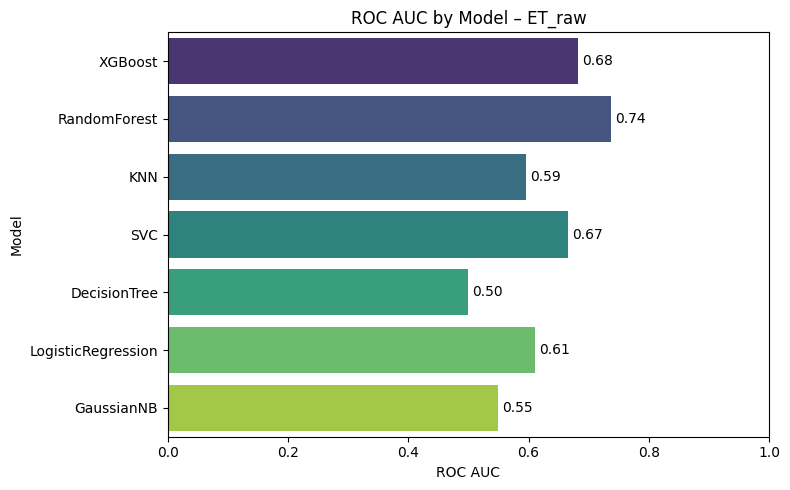

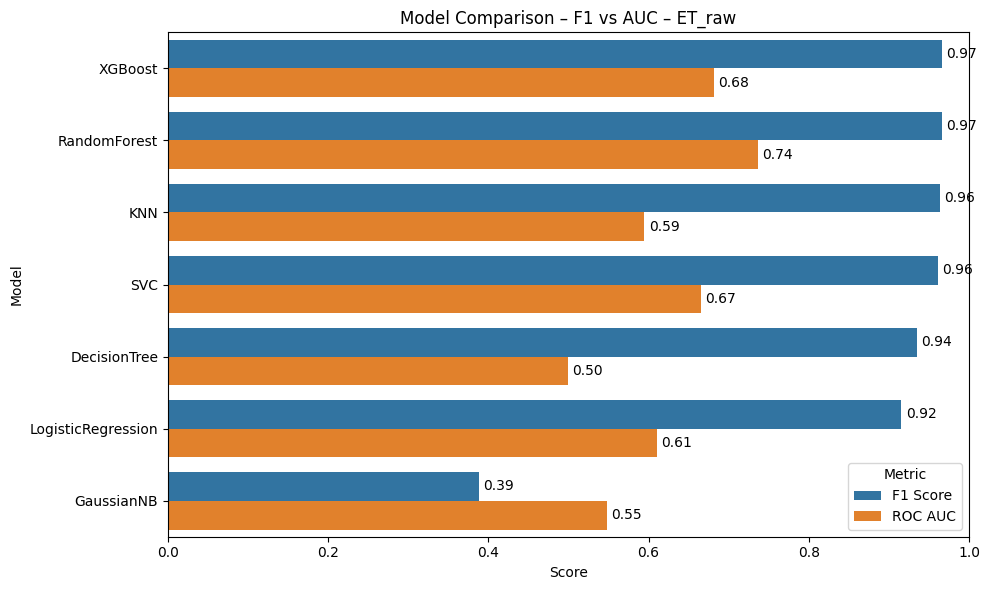

Plotting metrics for dataset: RF_raw


C:\Users\Abdullah\AppData\Local\Temp\ipykernel_14136\609682728.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='ROC AUC', y='Model', data=df, palette='viridis')


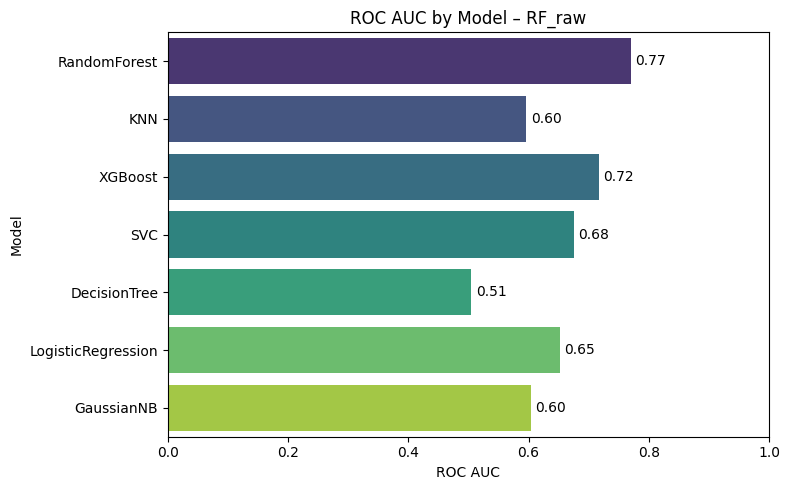

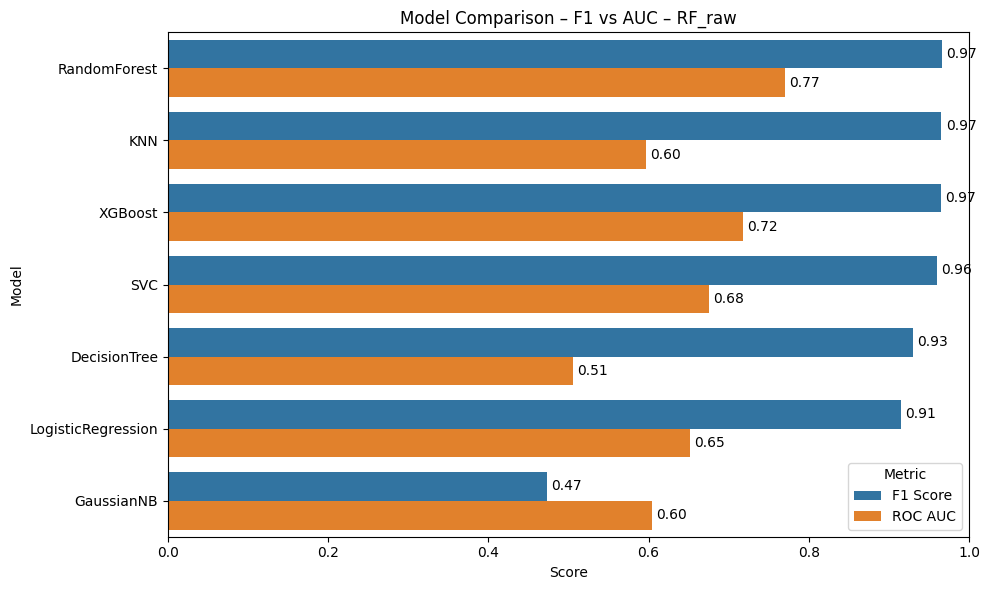

Plotting metrics for dataset: ET_uncorr


C:\Users\Abdullah\AppData\Local\Temp\ipykernel_14136\609682728.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='ROC AUC', y='Model', data=df, palette='viridis')


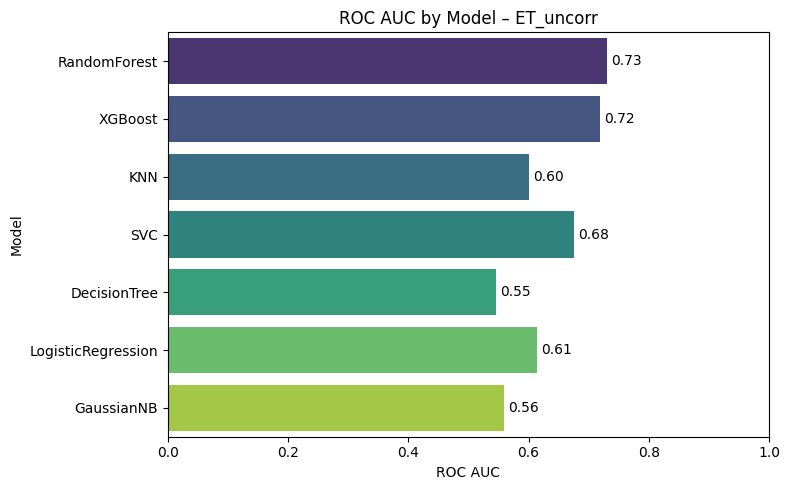

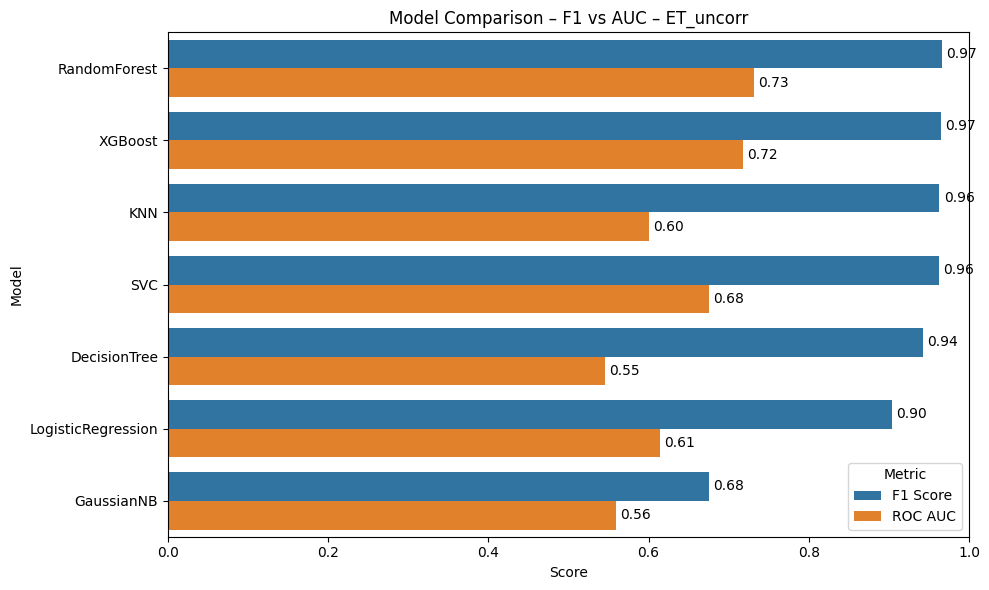

Plotting metrics for dataset: RF_uncorr


C:\Users\Abdullah\AppData\Local\Temp\ipykernel_14136\609682728.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='ROC AUC', y='Model', data=df, palette='viridis')


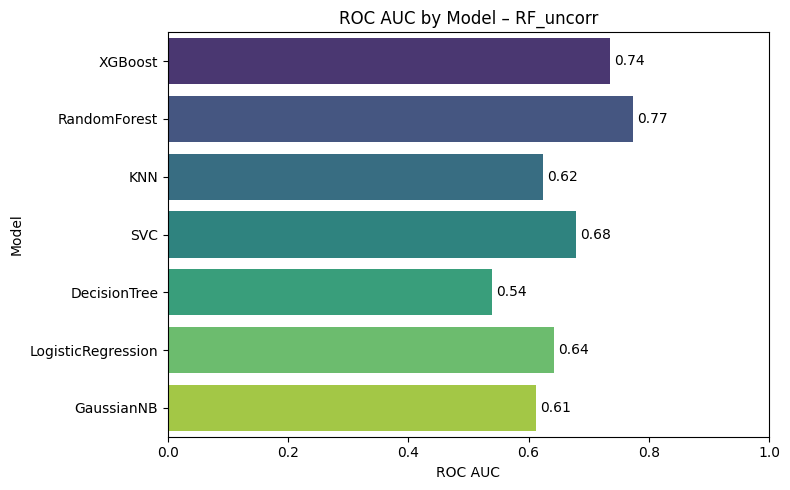

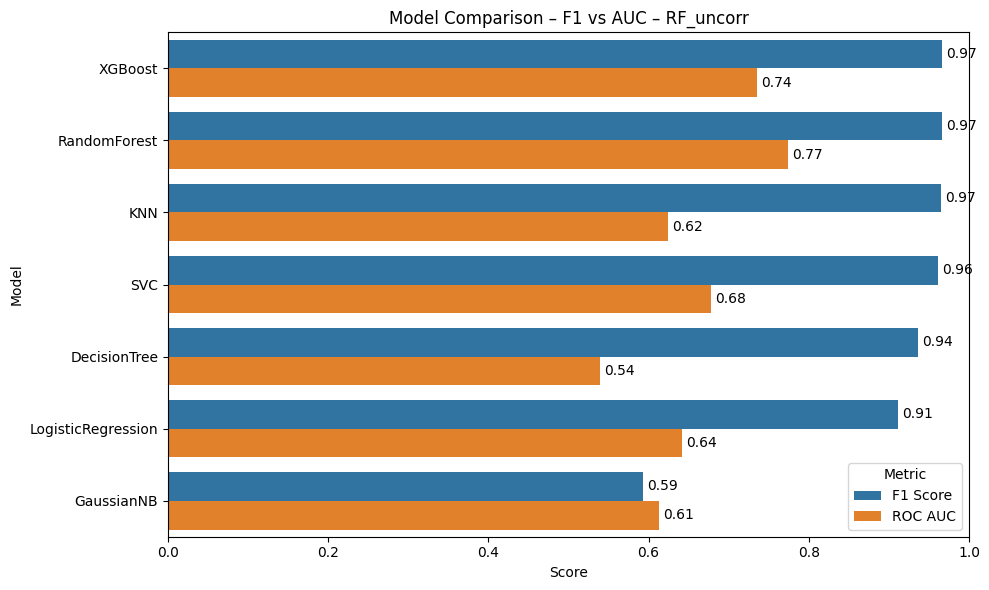

Plotting metrics for dataset: ET_PCA


C:\Users\Abdullah\AppData\Local\Temp\ipykernel_14136\609682728.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='ROC AUC', y='Model', data=df, palette='viridis')


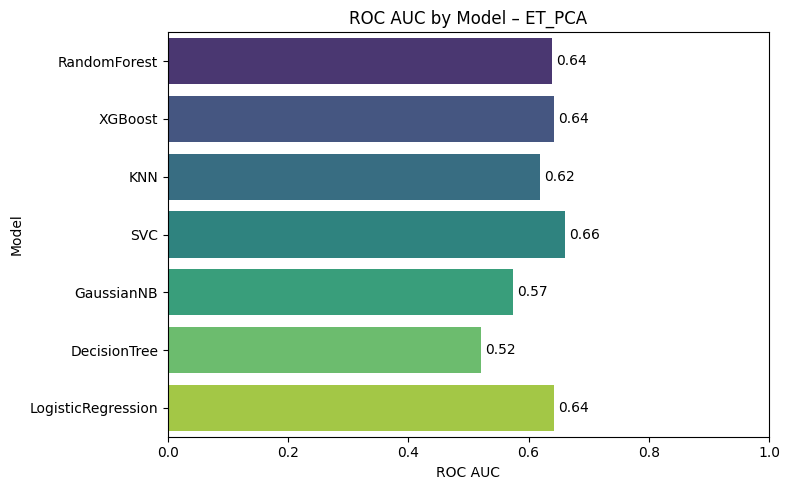

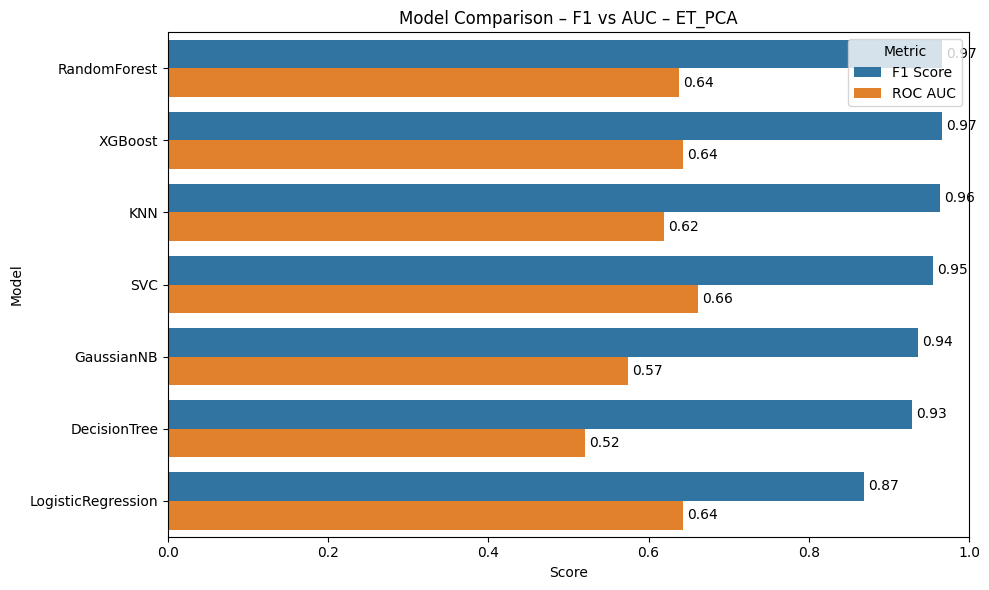

Plotting metrics for dataset: RF_PCA


C:\Users\Abdullah\AppData\Local\Temp\ipykernel_14136\609682728.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='ROC AUC', y='Model', data=df, palette='viridis')


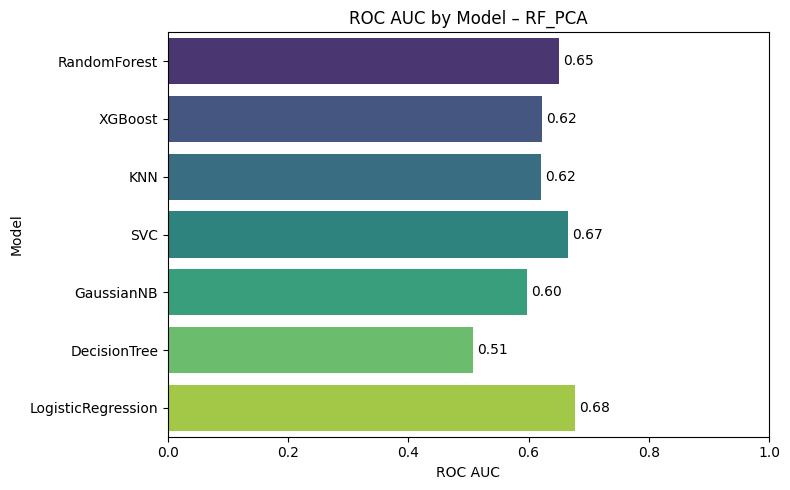

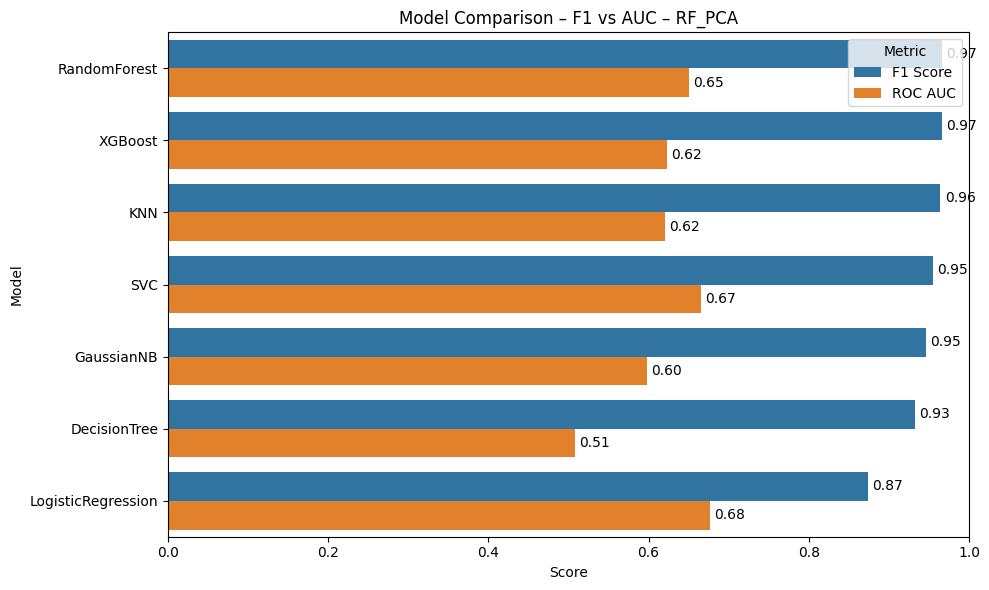

Plotting metrics for dataset: ET_PCA_uncorr


C:\Users\Abdullah\AppData\Local\Temp\ipykernel_14136\609682728.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='ROC AUC', y='Model', data=df, palette='viridis')


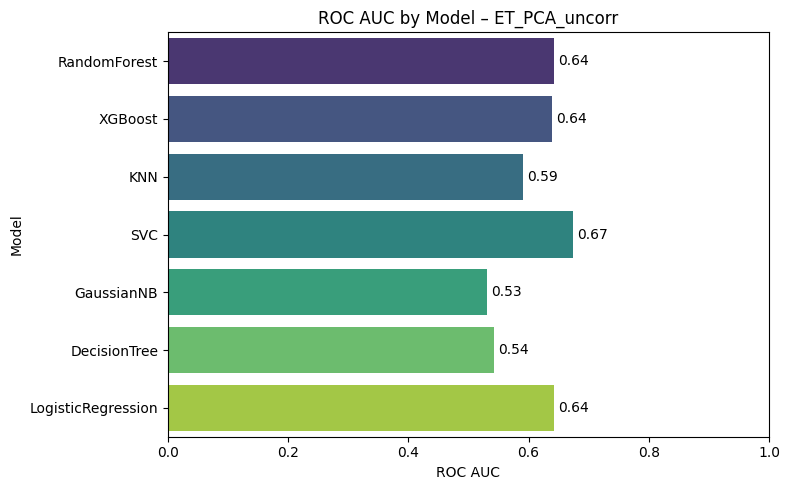

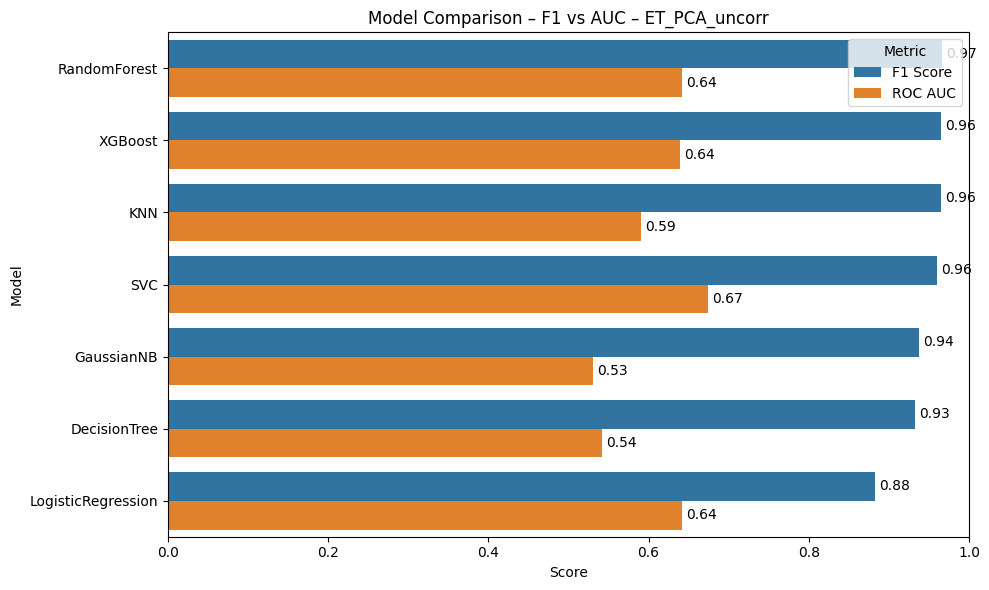

Plotting metrics for dataset: RF_PCA_uncorr


C:\Users\Abdullah\AppData\Local\Temp\ipykernel_14136\609682728.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='ROC AUC', y='Model', data=df, palette='viridis')


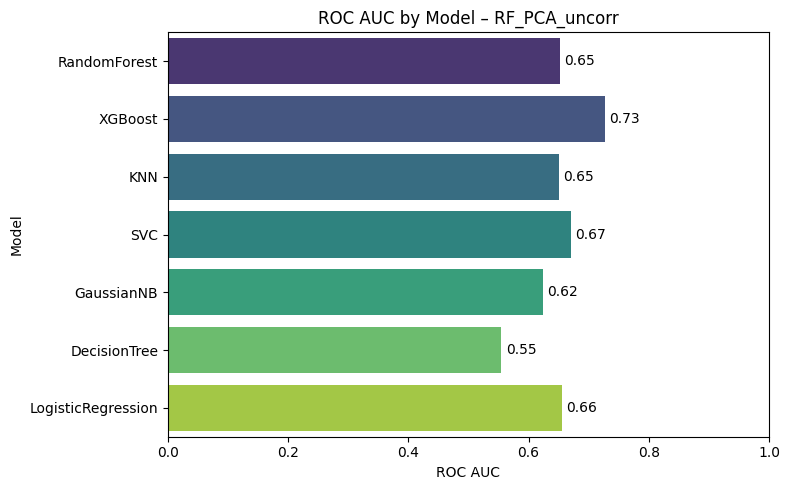

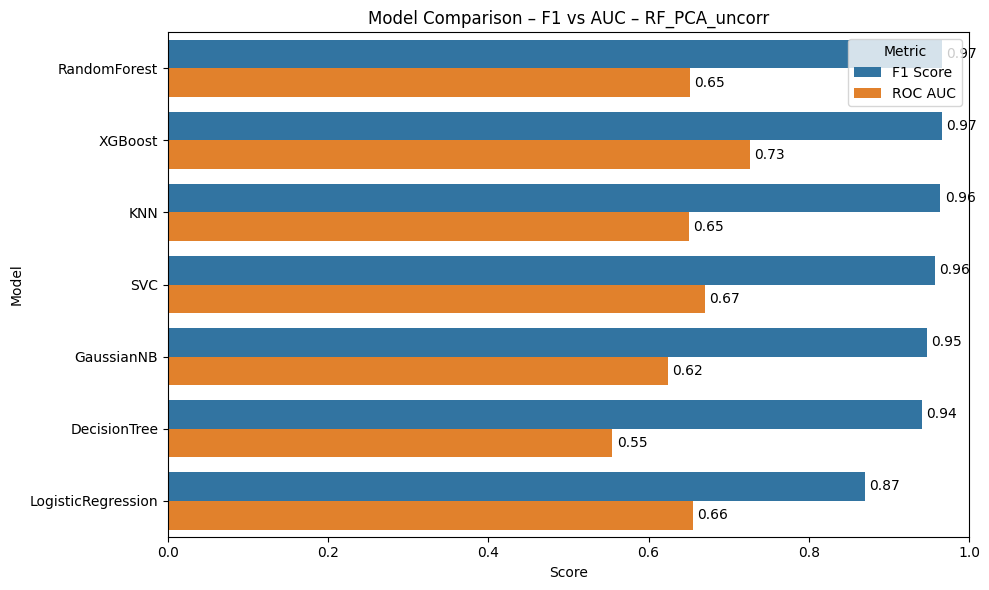

In [24]:
for dataset_name in cv_results.keys():
    print(f"Plotting metrics for dataset: {dataset_name}")
    plot_metrics_per_dataset(dataset_name)


In [25]:
def plot_model_across_datasets(metric='F1 Score'):
    combined = pd.concat(cv_results.values(), ignore_index=True)
    plt.figure(figsize=(10, 6))
    sns.barplot(x=metric, y='Dataset', hue='Model', data=combined)
    plt.title(f'{metric} Comparison – All Datasets')
    plt.xlim(0, 1)
    plt.tight_layout()
    plt.show()

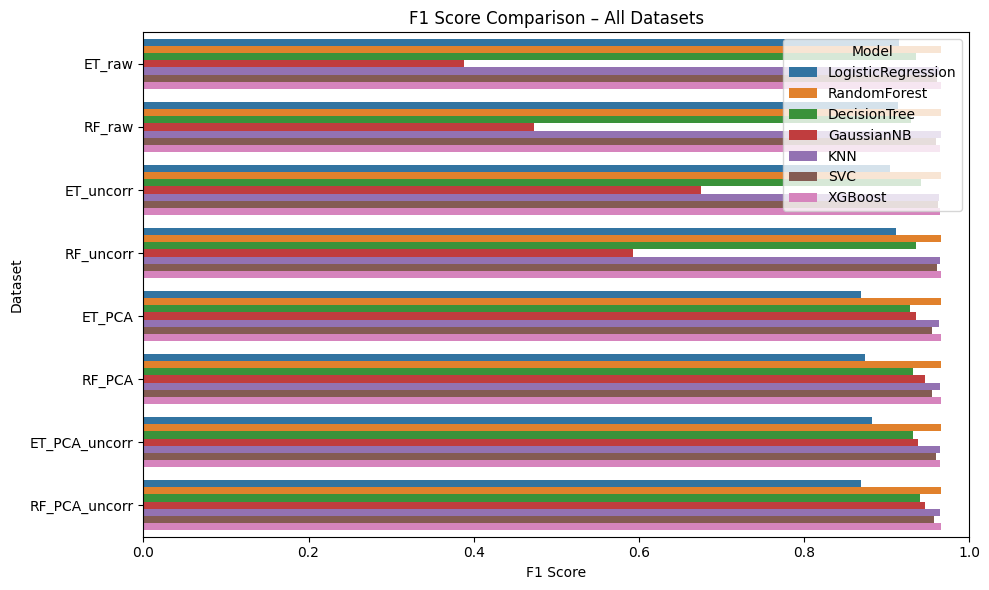

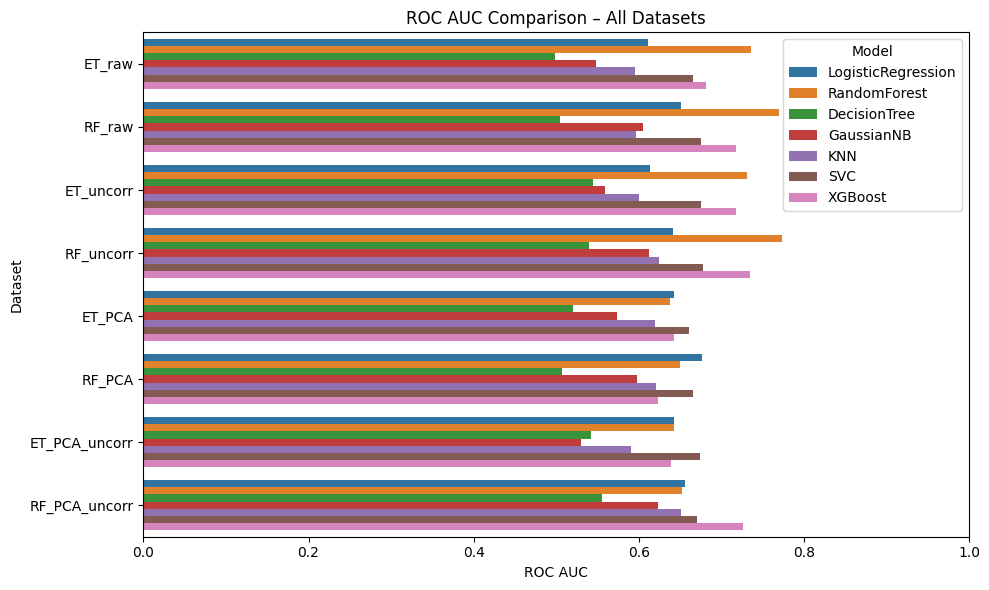

In [26]:
# F1 Score across datasets
plot_model_across_datasets(metric='F1 Score')

# ROC AUC across datasets
plot_model_across_datasets(metric='ROC AUC')


In [27]:
def plot_performance_heatmap(metric='F1 Score'):
    combined = pd.concat(cv_results.values(), ignore_index=True)
    pivot = combined.pivot(index='Model', columns='Dataset', values=metric)

    plt.figure(figsize=(12, 6))
    sns.heatmap(pivot, annot=True, fmt=".2f", cmap='YlGnBu')
    plt.title(f'{metric} Heatmap – Models vs Datasets')
    plt.tight_layout()
    plt.show()


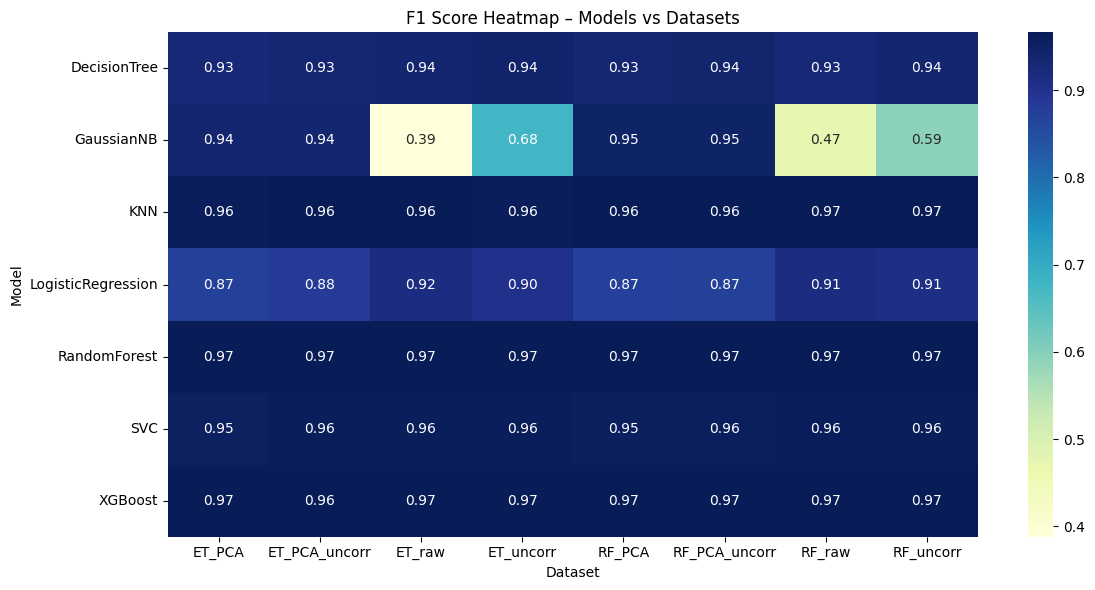

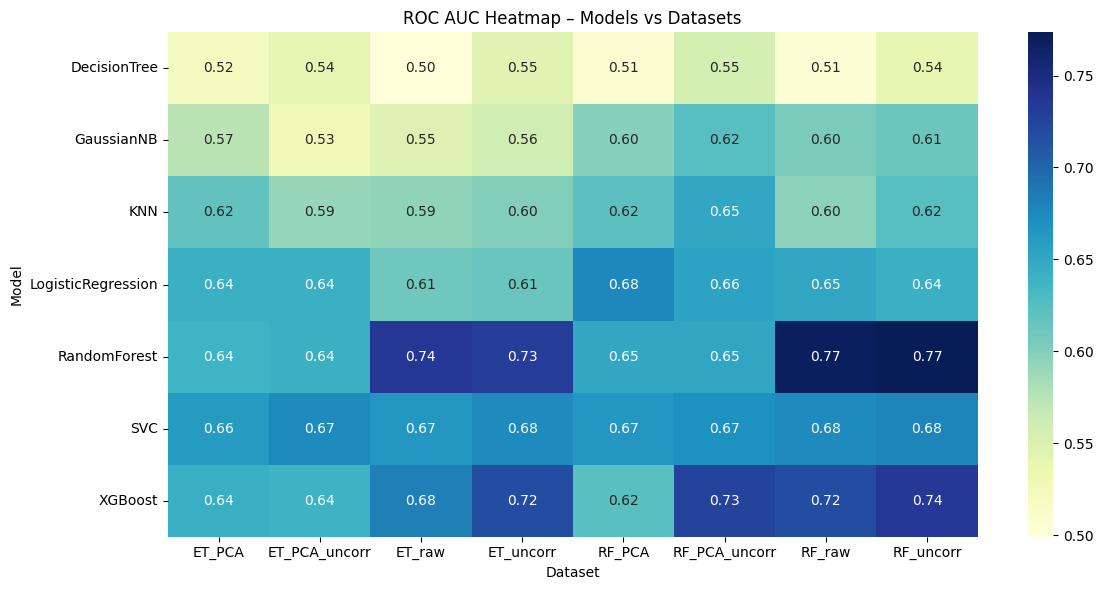

In [28]:
# Heatmap for F1 Score
plot_performance_heatmap(metric='F1 Score')

# Heatmap for ROC AUC
plot_performance_heatmap(metric='ROC AUC')


In [29]:
def plot_top3_roc_curves(dataset_name, n_splits=5):
    print(f"Plotting Top 3 ROC Curves for: {dataset_name}")

    df_scores = cv_results[dataset_name].sort_values(by='ROC AUC', ascending=False).head(3)
    data = splits[dataset_name]
    X, y = data['X_test'], data['y_test']
    X_train, y_train = data['X_train'], data['y_train']

    plt.figure(figsize=(8, 6))

    for _, row in df_scores.iterrows():
        model_name = row['Model']
        model = clone(models[model_name])

        # Collect FPR, TPR from each fold
        tprs = []
        aucs = []
        mean_fpr = np.linspace(0, 1, 100)

        skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
        for train_idx, val_idx in skf.split(X, y):
            model.fit(X_train, y_train)
            probas_ = model.predict_proba(X[val_idx])[:, 1]
            fpr, tpr, _ = roc_curve(y[val_idx], probas_)
            interp_tpr = np.interp(mean_fpr, fpr, tpr)
            interp_tpr[0] = 0.0
            tprs.append(interp_tpr)
            roc_auc = auc(fpr, tpr)
            aucs.append(roc_auc)
            plt.plot(fpr, tpr, color='grey', alpha=0.3)

        mean_tpr = np.mean(tprs, axis=0)
        mean_auc = np.mean(aucs)
        std_auc = np.std(aucs)
        mean_tpr[-1] = 1.0

        plt.plot(mean_fpr, mean_tpr, label=f"{model_name} (AUC = {mean_auc:.3f} ± {std_auc:.3f})", lw=2)

    plt.plot([0, 1], [0, 1], linestyle='--', color='red', lw=1)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f"Top 3 ROC Curves – {dataset_name}")
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


Plotting Top 3 ROC Curves for: ET_raw


c:\Users\Abdullah\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [21:23:33] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\Abdullah\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [21:23:35] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\Abdullah\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [21:23:36] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\Abdullah\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [21:23:38] WARNI

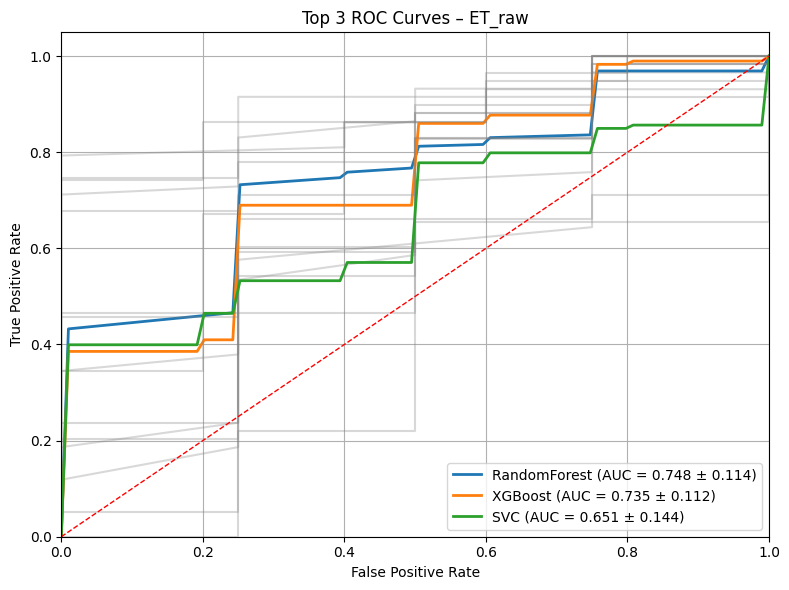

Plotting Top 3 ROC Curves for: RF_raw


c:\Users\Abdullah\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [21:24:11] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\Abdullah\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [21:24:13] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\Abdullah\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [21:24:15] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\Abdullah\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [21:24:17] WARNI

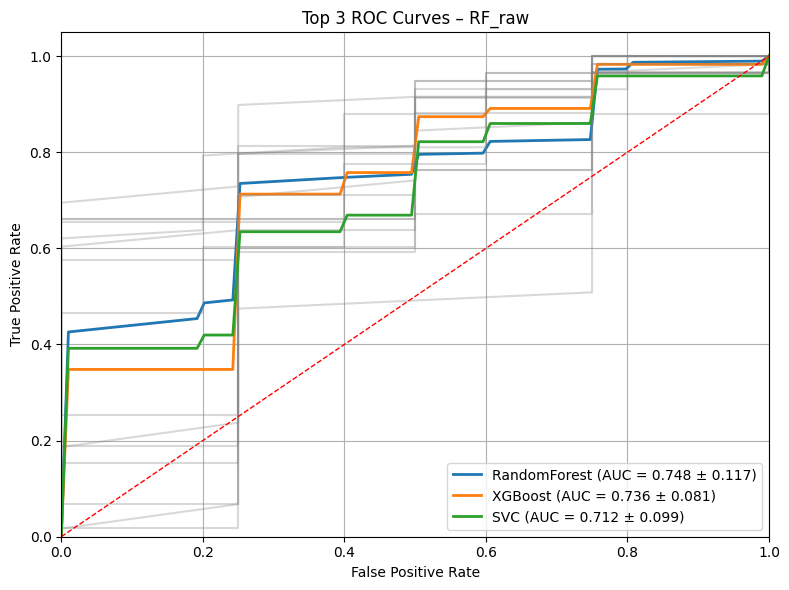

Plotting Top 3 ROC Curves for: ET_uncorr


c:\Users\Abdullah\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [21:24:45] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\Abdullah\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [21:24:46] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\Abdullah\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [21:24:47] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\Abdullah\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [21:24:48] WARNI

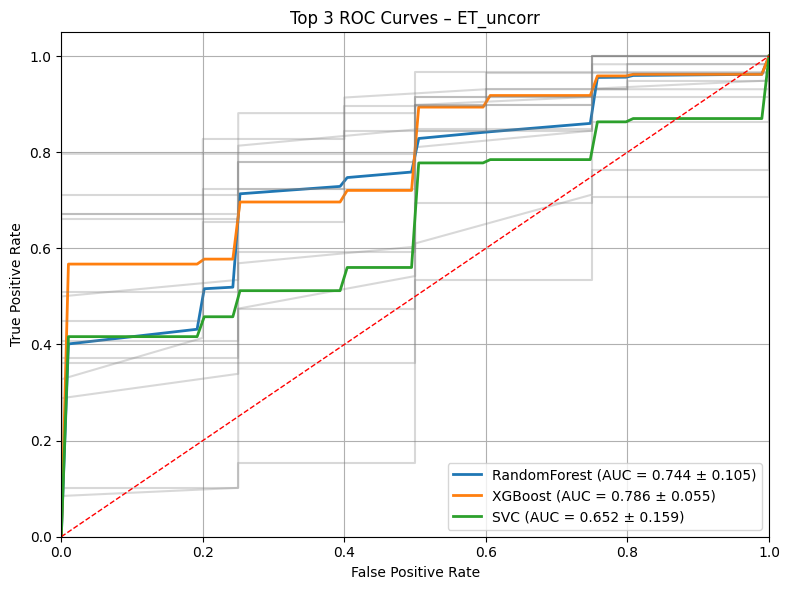

Plotting Top 3 ROC Curves for: RF_uncorr


c:\Users\Abdullah\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [21:25:12] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\Abdullah\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [21:25:13] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\Abdullah\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [21:25:14] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\Abdullah\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [21:25:15] WARNI

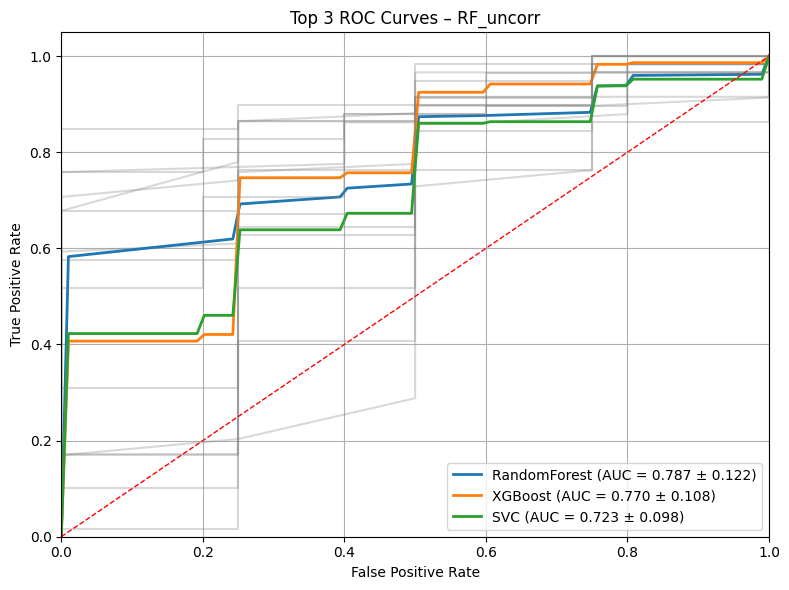

Plotting Top 3 ROC Curves for: ET_PCA


c:\Users\Abdullah\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [21:25:24] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\Abdullah\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [21:25:24] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\Abdullah\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [21:25:25] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\Abdullah\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [21:25:26] WARNI

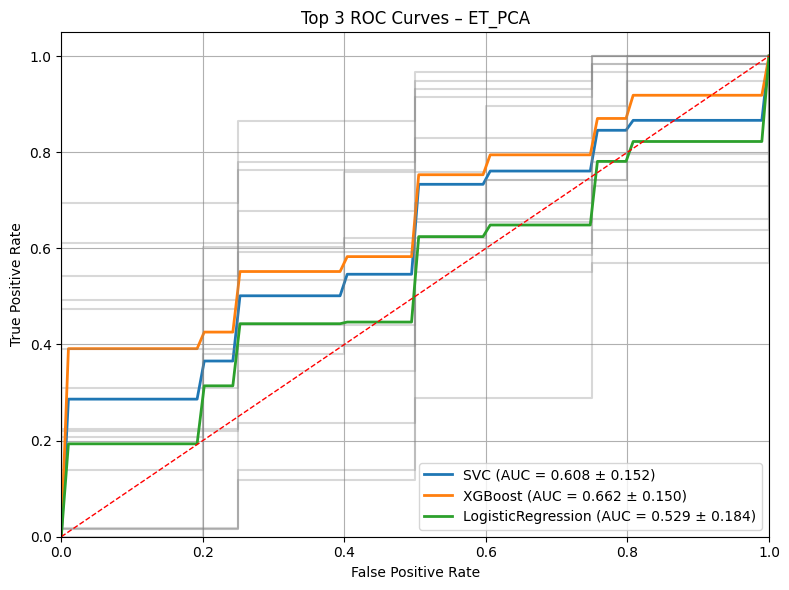

Plotting Top 3 ROC Curves for: RF_PCA


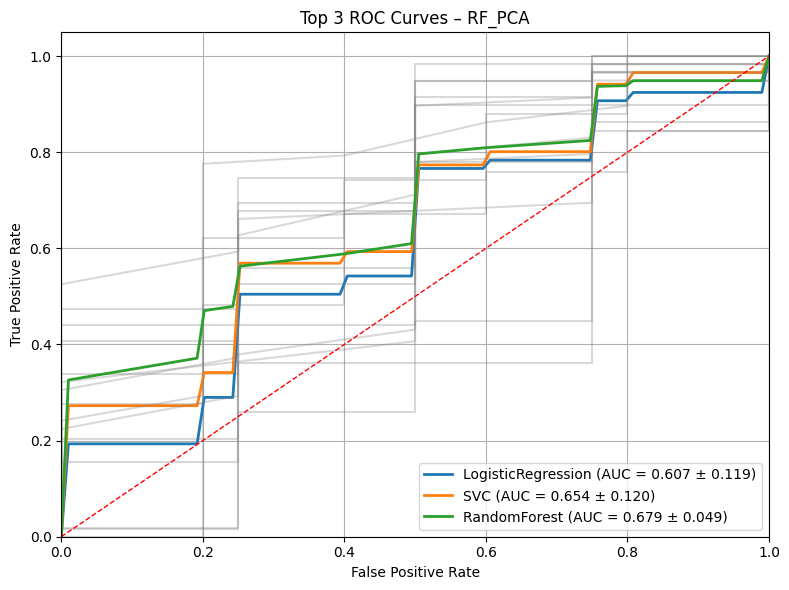

Plotting Top 3 ROC Curves for: ET_PCA_uncorr


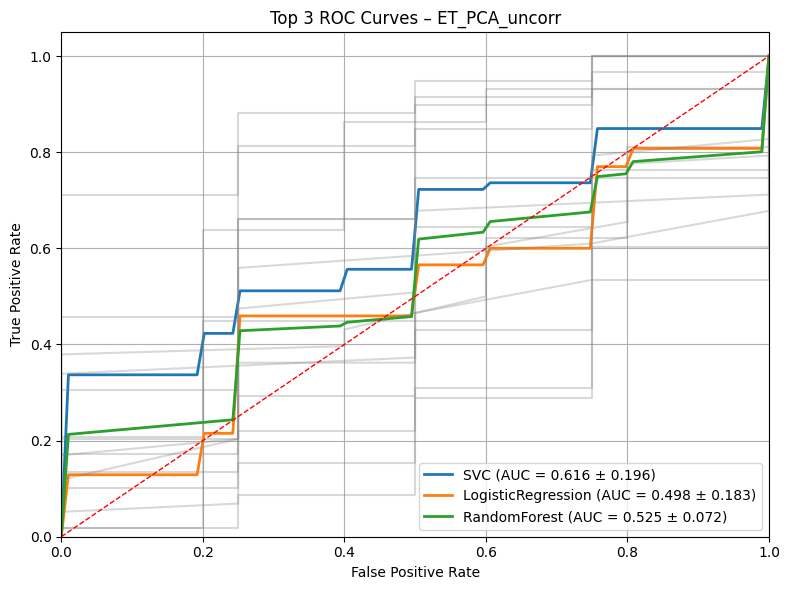

Plotting Top 3 ROC Curves for: RF_PCA_uncorr


c:\Users\Abdullah\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [21:26:06] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\Abdullah\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [21:26:06] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\Abdullah\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [21:26:07] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\Abdullah\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [21:26:08] WARNI

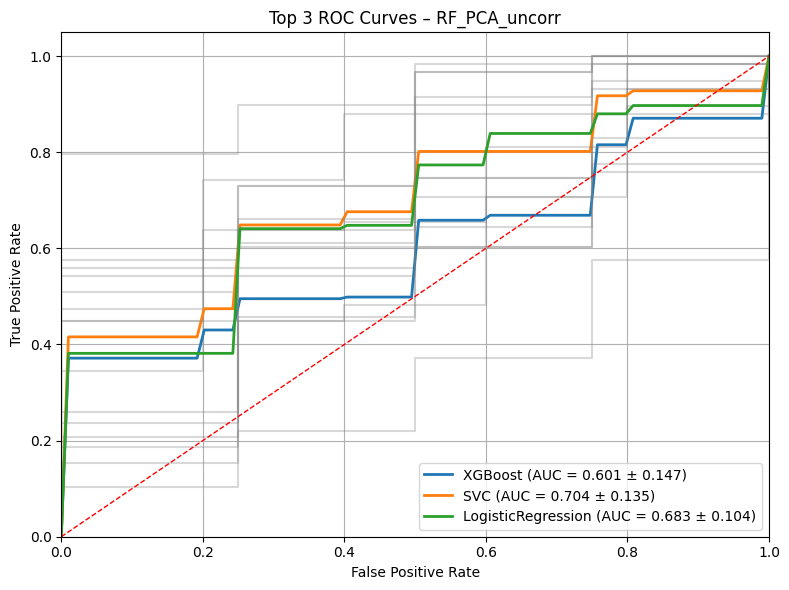

In [30]:
for name in splits.keys():
    plot_top3_roc_curves(name)
